# Anexo

En este anexo, se recogerán los datos guardados en archivos `csv` de la temperatura y de datos de las cosechas en Colombia durante distintos periodos de tiempo. Los uniremos y representaremos los datos para llegar a valores cuantificables y obtener las conclusiones del proyecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
import re

data_m = pd.read_csv("Cadena_Productiva_Maiz_-_Area__Produccion_Y_Rendimiento.csv")
data_t = pd.read_csv("tmean_gathered.csv")

%matplotlib inline

Observemos cómo están ordenados los datos:

In [2]:
data_m.head(3)

,CÓD. DEP.,DEPARTAMENTO,CÓD. MUN.,MUNICIPIO,GRUPO DE CULTIVO,SUBGRUPO DE CULTIVO,CULTIVO,DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO,CÓDIGO CULTIVO,NOMBRE CIENTIFICO,PERIODO,Área Sembrada(ha),Área Cosechada(ha),Producción(t),Rendimiento(t/ha),ESTADO FISICO PRODUCCION
0,5,ANTIOQUIA,5579,PUERTO BERRIO,CEREALES,MAIZ FORRAJERO,MAIZ FORRAJERO,MAIZ FORRAJERO,1060101,ZEA MAYS,2018A,150,150,4200,28.0,GRANO SECO
1,5,ANTIOQUIA,5400,LA UNION,CEREALES,MAIZ FORRAJERO,MAIZ FORRAJERO,MAIZ FORRAJERO,1060101,ZEA MAYS,2018A,23,22,726,33.0,GRANO SECO
2,20,CESAR,20250,EL PASO,CEREALES,MAIZ FORRAJERO,MAIZ FORRAJERO,MAIZ FORRAJERO,1060101,ZEA MAYS,2018A,320,74,222,3.0,GRANO SECO


In [3]:
data_t.head(3)

,AREA_HA,CODIGO_VER,COD_DPTO,DESCRIPCIO,DPTOMPIO,FUENTE,NOMBRE_VER,NOMB_MPIO,NOM_DEP,OBJECTID,OBSERVACIO,SEUDONIMOS,VIGENCIA,cat,SEMESTRE,TMEAN
0,7099.487596,95001008,95,NaN,95001,DANE - ESRI,LA ORQUIDEA,SAN JOSÉ DEL GUAVIARE,GUAVIARE,27948,NaN,1.0,ESRI,26991,2015A,25.822514
1,7099.487596,95001008,95,NaN,95001,DANE - ESRI,LA ORQUIDEA,SAN JOSÉ DEL GUAVIARE,GUAVIARE,27948,NaN,1.0,ESRI,26991,2015B,25.984380
2,7099.487596,95001008,95,NaN,95001,DANE - ESRI,LA ORQUIDEA,SAN JOSÉ DEL GUAVIARE,GUAVIARE,27948,NaN,1.0,ESRI,26991,2016A,26.699660


Creamos dos listas qeu contengan el nombre de las columnas que nos interesen de cada tabla. Estas serán aquellas que cuantifiquen la producción de maíz y la temperatura y luego el identificador del departamento y el periodo de tiempo. También eliminamos los datos que contengan producción 0 puesto que no ofrecen información e incluso puede llegar a significar que el dato es nulo dentro del archivo.

In [4]:
indices_t = ['COD_DPTO', 'SEMESTRE', 'TMEAN']
indices_m = ['CÓD. DEP.', 'PERIODO', 'Rendimiento(t/ha)', 'Producción(t)', 'Área Cosechada(ha)', 'Área Sembrada(ha)']


data_mm = data_m[data_m['Producción(t)'] != 0.] # Borramos los datos que tengan producción 0

Cogiendo la tabla de los datos agrícolas, agrupamos los datos que tengan el mismo departamento y el mismo periodo de 6 meses (sumamos la producción, el rendimiento, etc.).

In [5]:
def add_everything_m(df):
    temp = df[indices_m[2:]].sum()
    return temp

dd = data_mm.groupby(by = indices_m[:2], axis = 0, as_index = False).apply(add_everything_m).reset_index()

Hacemos los mismo para la temperatura pero cogemos la media:

In [6]:
mm = data_t[indices_t].groupby(by = indices_t[:2], axis = 0, as_index = False).mean()

Unimos ambas tablas en una sola por departamento y periodo de tiempo. Además cambiamos el nombre de las columnas:

In [7]:
merged = dd.merge(right = mm,
                             how = 'inner',
                             left_on = dd.columns.tolist()[:2],
                             right_on = mm.columns.tolist()[:2])

merged.drop(columns = mm.columns.tolist()[:2], inplace = True) # Borramos las columnas indices de una de las tablas
merged.columns = ['departamento','periodo', 'rendimiento', 'produccion', 'cosechada', 'sembrada', 'temp']

In [8]:
merged.to_csv('./datos_cosecha_temp.csv', index = False)
merged.head()

,departamento,periodo,rendimiento,produccion,cosechada,sembrada,temp
0,5,2015A,150.0,26145.0,13531.0,15445.0,21.401455
1,5,2015B,154.9,28301.0,16261.0,14118.0,21.655113
2,5,2016A,137.3,25275.0,13356.0,15253.0,22.082711
3,5,2016B,255.8,31356.0,15815.0,15829.0,20.235452
4,5,2017A,222.4,28772.0,14148.0,12942.0,20.427394


Tomamos la relación entre la producción en toneladas y el área cosechada. Proponemos que siguen una relación de proporcionalidad directa:
$$Y = \alpha X$$

Creamos un modelo logarítmico y lo ajustamos a los datos:

In [18]:
def ff(x, m,n):
    return(np.exp(np.log(x)*m + n))

popt, pcov = opt.curve_fit(ff, xdata = merged['cosechada'], ydata = merged['produccion'], p0 = [1, 0.1],
                          method = 'trf',
                          bounds = ([0.9, -np.inf], [1.1, np.inf]))
err_t = -stats.t(merged.shape[0]-3).ppf(0.05/2)
interval = np.sqrt(np.diag(pcov))*err_t

In [10]:
pd.DataFrame({'Params': popt,
             'Errores' : interval,
            'Errores (rel)' : interval/popt})

,Params,Errores,Errores (rel)
0,1.100000,0.107960,0.098146
1,0.203505,1.111249,5.460555


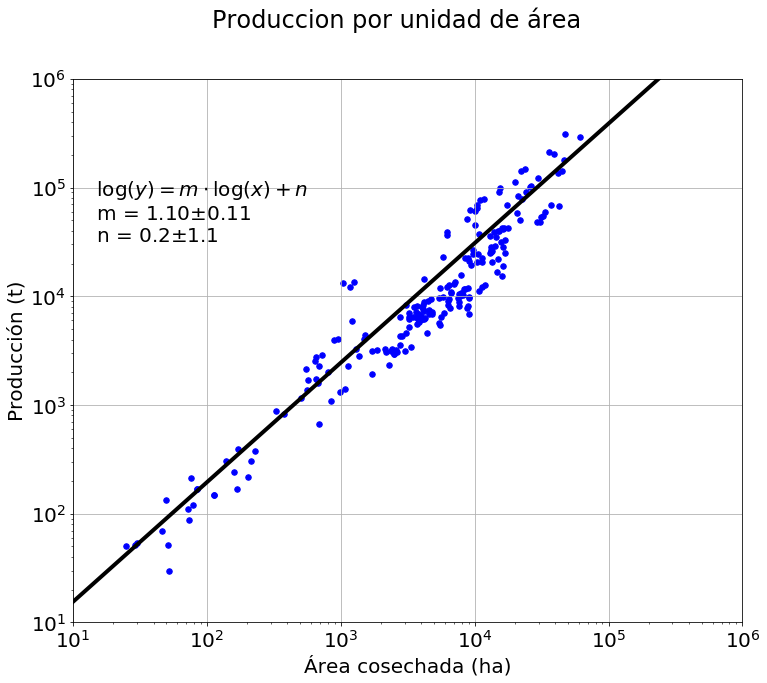

In [19]:
colour = ['b', 'g', 'r', 'c']

fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
plt.rc('font', size=20)

plt.scatter('cosechada', 'produccion', data = merged,
         color = 'blue',
         s = 30,
         )

xx = np.logspace(1,
                 6, 100)

plt.plot(xx, ff(xx, *popt),
         color = 'black',
         linewidth = 4,
         label = 'Ajuste')

eq = r'''
         $\log(y) = m \cdot \log(x) + n$
         m = ''' + "{0:.2f}".format(popt[0]) + '''$\pm$''' + "{0:.2f}".format(interval[0]) + '''
         n = ''' + "{0:.1f}".format(popt[1]) + '''$\pm$''' + "{0:.1f}".format(interval[1])

plt.text(-0.05,0.7,
         s = eq,
         transform=ax.transAxes)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e1, 1e6)
ax.set_ylim(1e1, 1e6)

fig.suptitle('Produccion por unidad de área')
plt.xlabel('Área cosechada (ha)')
plt.ylabel('Producción (t)')
plt.grid()
fig.savefig('cosecha.png')
plt.show()

Ahora buscamos la relación entre la temperatura y el rendimiento de la tierra. Como los datos se encuentran muy dispersos, los agrupamos en intervalos regulares de temperatura para simplificar el problema.

In [12]:
def ff(df):
    return pd.Series({'temp': df['temp'].mean(),
                      'rendimiento.mean': df['rendimiento'].mean(),
                      'rendimiento.std': df['rendimiento'].std()})

cos = merged[['temp', 'rendimiento']].groupby(pd.cut(merged['temp'], np.arange(10, 31, 2.5))).apply(ff).dropna(axis = 0, how = 'any')

In [13]:
cos

,temp,rendimiento.mean,rendimiento.std
temp,,,
"(10.0, 12.5]",10.813844,1.300000,0.519615
"(15.0, 17.5]",16.509104,92.027273,39.842643
"(17.5, 20.0]",18.952998,96.553846,87.782383
"(20.0, 22.5]",21.093960,154.132609,105.474071
"(22.5, 25.0]",24.009160,75.180645,90.996258
"(25.0, 27.5]",25.971555,32.289583,53.316299
"(27.5, 30.0]",28.518000,52.005556,30.712621


Haremos un modelo normal para los datos obtenidos:

In [14]:
def ff(x, mu, sig, sca):
    return(stats.norm(loc = mu, scale = sig).pdf(x)*sca)

popt, pcov = opt.curve_fit(ff, xdata = cos['temp'], ydata = cos['rendimiento.mean'], p0 = [21, 5, 1800])
err_t = -stats.t(cos.shape[0]-3).ppf(0.05/2)
interval = np.sqrt(np.diag(pcov))*err_t

In [15]:
pd.DataFrame({'Params': popt,
             'Errores' : interval,
            'Errores (rel)' : interval/popt})

,Params,Errores,Errores (rel)
0,20.391157,2.363285,0.115898
1,4.107154,2.576097,0.627222
2,1320.222426,673.183124,0.509901


Representamos los datos el la aproximación del modelo. Encontramos así la temperatura óptima para conseguir el mayor rendimiento.

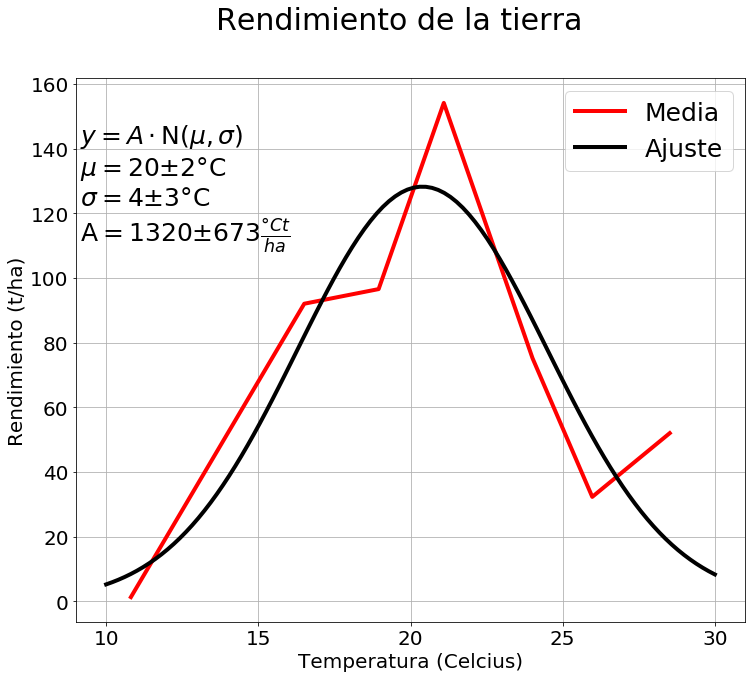

In [16]:
colour = ['b', 'g', 'r', 'c']

fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1)
plt.rc('font', size=25)

plt.plot('temp', 'rendimiento.mean', data = cos.dropna(axis = 0, how = 'any'),
         color = colour[2],
         linewidth = 4,
         label = 'Media')

xx = np.linspace(10,
                 30, 100)
plt.plot(xx, ff(xx, *popt),
         color = 'black',
         linewidth = 4,
         label = 'Ajuste')

eq = r'''
         $y = A \cdot \mathrm{N}(\mu, \sigma)$
         $\mu = $''' + "{0:.0f}".format(popt[0]) + '''$\pm$''' + "{0:.0f}".format(interval[0]) + '''$\degree$C
         $\sigma = $''' + "{0:.0f}".format(popt[1]) + '''$\pm$''' + "{0:.0f}".format(interval[1]) + '''$\degree$C
         A$ = $''' + "{0:.0f}".format(popt[2]) + '''$\pm$''' + "{0:.0f}".format(interval[2]) + r'''$\frac{\degree C t}{ha}$'''

plt.text(-0.1,0.7,
         s = eq,
         transform=ax.transAxes)

fig.suptitle('Rendimiento de la tierra')
plt.xlabel('Temperatura (Celcius)')
plt.ylabel('Rendimiento (t/ha)')
plt.legend()
plt.grid()
fig.savefig('rendimiento.png')
plt.show()